### Deep Deterministic Policy Gradients 

Taken from my Assignment 4

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gym
import pybullet
import pybulletgym.envs

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
 
import matplotlib.pyplot as plt
 
from collections import deque
import numpy as np
import random
import time
import copy
import pickle

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [3]:
def weighSync(target_model, source_model, tau=0.001):
    '''
    A function to soft update target networks
    '''
    for target_param, source_param in zip(target_model.parameters(), source_model.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + source_param.data * tau)  

In [4]:
class Replay():
    def __init__(self, buffer_size, init_length, state_dim, action_dim, env):
        """
        A function to initialize the replay buffer.

        param: init_length : Initial number of transitions to collect
        param: state_dim : Size of the state space
        param: action_dim : Size of the action space
        param: env : gym environment object
        """
        self.buffer_size = buffer_size  
        self.init_length = init_length  
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.env = env

        self._buffer = deque()  

        if self.env is not None:    
            self.init_test()
            
    def init_test(self):
        
        count = 0
        flag = False
        while not flag:
            done = False
            state = self.env.reset()
            step = 1
            while not done:
                action = self.env.action_space.sample()     # sample random action
                state_next, reward, done, info = self.env.step(action)
                step += 1

                dic = {'state': state,
                       'action': action,
                       'reward': reward,
                       'state_next': state_next,
                       'done': done}
                if step == 150:
                    dic['done'] = False      # NOTE: 150 is not done
                self.buffer_add(dic)

                state = state_next
                count += 1

                if count >= self.init_length:
                    flag = True
                    break

    
    def buffer_add(self, exp):
        """
        A function to add a dictionary to the buffer
        :param exp : A dictionary consisting of state, action, reward , next state and done flag
        """
        
        self._buffer.append(exp)

        if len(self._buffer) > self.buffer_size:
            self._buffer.popleft()

    def buffer_sample(self, N):
        """
        A function to sample N points from the buffer
        :param N : Number of samples to obtain from the buffer
        """
        return random.sample(self._buffer, N)


In [5]:
class Actor(nn.Module):
    
    def __init__(self, state_dim, action_dim):
        """
        Initialize the network
        :param state_dim : Size of the state space
        :param action_dim: Size of the action space
        """
        super(Actor, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim


        self.layer_1 = nn.Linear(self.state_dim, 400)
        

        self.layer_2 = nn.Linear(400, 300)
        

        self.layer_3 = nn.Linear(300, self.action_dim)

        
        self.layer_1.weight.data.uniform_(-1/np.sqrt(self.state_dim), 1/np.sqrt(self.state_dim))
        self.layer_1.weight.data.uniform_(-1/np.sqrt(400),1/np.sqrt(400))
        self.layer_3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        """
        Define the forward pass
        param: state: The state of the environment
        """
        if isinstance(state, np.ndarray):
            x = torch.FloatTensor(state)
        else:
            x = state
            
        x = self.layer_1(x)
        x = F.relu(x)

        x = self.layer_2(x)
        x = F.relu(x)

        x = self.layer_3(x)
        x = torch.tanh(x)
        return x

In [6]:
class Critic(nn.Module):

    def __init__(self, state_dim, action_dim):
        """
        Initialize the critic
        :param state_dim : Size of the state space
        :param action_dim : Size of the action space
        """
        super(Critic, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim


        self.layer_1 = nn.Linear(self.state_dim, 400)
        self.layer_2 = nn.Linear(400 + self.action_dim, 300)
        self.layer_3 = nn.Linear(300, 1)

        self.layer_1.weight.data.uniform_(-1/np.sqrt(self.state_dim), 1/np.sqrt(self.state_dim))
        self.layer_2.weight.data.uniform_(-1/np.sqrt(400 + self.action_dim), 1/np.sqrt(400 + self.action_dim))
        self.layer_3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """
        Define the forward pass of the critic
        """
        if isinstance(state, np.ndarray):
            x = torch.FloatTensor(state)
        else:
            x = state
            
        if isinstance(action, np.ndarray):
            a = torch.FloatTensor(action)
        else:
            a = action
            
        x = self.layer_1(x)
        x = F.relu(x)
            
        x = torch.cat((x, a), 1)
        x = self.layer_2(x)
        x = F.relu(x)

        x = self.layer_3(x)
        return x

    

In [7]:
class DDPG():
    def __init__(
            self,
            env,
            state_dim,
            action_dim,
            critic_lr=3e-4,
            actor_lr=3e-4,
            gamma=0.99,
            batch_size=100,
    ):
        """
        :param env: An gym environment
        :param state_dim: Size of state space
        :param action_dim: Size of action space
        :param critic_lr: Learning rate of the critic
        :param actor_lr: Learning rate of the actor
        :param gamma: The discount factor
        :param batch_size: The batch size for training
        """
        self.gamma = gamma
        self.batch_size = batch_size
        self.env = env
        self.test_env = copy.deepcopy(env)  

        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.ReplayBuffer = Replay(buffer_size=10000,
                                   init_length=1000,
                                   state_dim=state_dim,
                                   action_dim=action_dim,
                                   env=env)

    def get_action(self, state):
        # noise with 0.1 variance
        noise = np.random.multivariate_normal(mean=[0, 0], cov=np.diag([0.1, 0.1]))
        action = self.actor(torch.FloatTensor(state).to(device)).cpu().detach().numpy() + noise 
        return np.clip(action, -1, 1)

    def update_target_networks(self):
        """
        A function to update the target networks
        """
        weighSync(self.actor_target, self.actor)
        weighSync(self.critic_target, self.critic)

    def update_network(self, batch):
        """
        A function to update the function just once
        """

        batch_size = len(batch)
        batch_state = []
        batch_action = []
        batch_reward = []
        batch_next_state = []
        batch_not_done = []
        
        
        for dic in batch:
            batch_state.append(torch.FloatTensor(dic['state']))
            batch_action.append(torch.FloatTensor(dic['action']))
            batch_reward.append(torch.FloatTensor([dic['reward']]))
            batch_next_state.append(torch.FloatTensor(dic['state_next']))
            batch_not_done.append(torch.FloatTensor([not dic['done']]))

        batch_state = torch.cat(batch_state).reshape(batch_size, -1).to(device)
        batch_action = torch.cat(batch_action).reshape(batch_size, -1).to(device)
        batch_reward = torch.cat(batch_reward).reshape(batch_size, -1).to(device)
        batch_next_state = torch.cat(batch_next_state).reshape(batch_size, -1).to(device)
        batch_not_done = torch.cat(batch_not_done).reshape(batch_size, -1).to(device)


        batch_next_action = self.actor_target.forward(batch_next_state)
        tar_Q = self.critic_target.forward(batch_next_state, batch_next_action)

        tar_Q = batch_reward + \
            (self.gamma * batch_not_done * tar_Q)

        current_Q = self.critic.forward(batch_state, batch_action)

        self.optimizer_critic.zero_grad()
        critic_loss = F.mse_loss(current_Q, tar_Q)
        critic_loss.backward()
        self.optimizer_critic.step()

        self.optimizer_actor.zero_grad()
        actor_loss = - self.critic(batch_state,
                                   self.actor(batch_state)).mean()
        actor_loss.backward()
        self.optimizer_actor.step()

        self.update_target_networks()

        return critic_loss.item(), actor_loss.item()

    def test_Pi_eval(self):
        state = self.test_env.reset()

        count = 0
        average_reward = 0
        done = False
        while not done:
            action = self.actor(torch.FloatTensor(state).to(
                device)).cpu().detach().squeeze().numpy()
            next_state, r, done, _ = self.test_env.step(action)
            state = next_state
            count += 1
            average_reward += r

        average_reward /= count
        
        return count, average_reward


    
    def train(self, num_steps):
        """
        Train the policy for the given number of iterations
        :param num_steps: The number of steps to train the policy for
        """
        time_start = time.time()

        critic_loss = []
        actor_loss = []
        eval_steps = []
        avg_reward = []
        traj_step = 1
        state = self.env.reset()

        for i in range(num_steps):
            
            action = self.get_action(state)
            state_next, reward, done, _ = self.env.step(action)     
            traj_step += 1

            dic = {'state': state,
                   'action': action,
                   'reward': reward,
                   'state_next': state_next,
                   'done': done}
            if traj_step == 150:
                dic['done'] = False      
            self.ReplayBuffer.buffer_add(dic)


            state = state_next

            if done:
                traj_step = 1
                state = self.env.reset()

            
            batch = self.ReplayBuffer.buffer_sample(self.batch_size)

            critic_loss_i, actor_loss_i = self.update_network(batch)

            critic_loss.append(critic_loss_i)
            actor_loss.append(actor_loss_i)

            if i % 100 == 0:
                
                eval_step, eval_average_reward = self.test_Pi_eval()
                eval_steps.append(eval_step)
                avg_reward.append(eval_average_reward)
                print('step {}, critic_loss = {:.4f}, actor_loss = {:.4f}'
                      .format(i, critic_loss_i, actor_loss_i))

        return critic_loss, actor_loss, eval_steps, avg_reward

In [8]:
np.random.seed(1000)
# env = gym.make("modified_gym_env:ReacherPyBulletEnv-v1", rand_init=False)
# env = gym.make("LunarLander-v2")
env = gym.make("LunarLanderContinuous-v2")
ddpg_object = DDPG(
    env,
    8,
    2,
    critic_lr=1e-3,
    actor_lr=1e-3,
    gamma=0.99,
    batch_size=100,
    )
 
critic_loss, actor_loss, eval_step, average_reward = ddpg_object.train(200000)

step 0, critic_loss = 122.6812, actor_loss = -0.0042
step 100, critic_loss = 3.1470, actor_loss = 1.9435
step 200, critic_loss = 3.6700, actor_loss = 2.0900
step 300, critic_loss = 7.7185, actor_loss = 1.6157
step 400, critic_loss = 5.5988, actor_loss = 2.7983
step 500, critic_loss = 3.0025, actor_loss = 3.5004
step 600, critic_loss = 105.4177, actor_loss = 4.3507
step 700, critic_loss = 45.9520, actor_loss = 4.3625
step 800, critic_loss = 34.8913, actor_loss = 6.9603
step 900, critic_loss = 59.3225, actor_loss = 5.7562
step 1000, critic_loss = 127.0354, actor_loss = 8.1052
step 1100, critic_loss = 62.6065, actor_loss = 6.7451
step 1200, critic_loss = 5.9632, actor_loss = 6.4046
step 1300, critic_loss = 20.0702, actor_loss = 6.6499
step 1400, critic_loss = 46.0982, actor_loss = 8.4642
step 1500, critic_loss = 34.3472, actor_loss = 8.6875
step 1600, critic_loss = 68.2504, actor_loss = 9.6594
step 1700, critic_loss = 81.9572, actor_loss = 10.3279
step 1800, critic_loss = 11.5002, actor_l

step 15200, critic_loss = 0.6909, actor_loss = 0.0555
step 15300, critic_loss = 0.7767, actor_loss = -1.5565
step 15400, critic_loss = 0.8227, actor_loss = -1.5823
step 15500, critic_loss = 1.3453, actor_loss = -0.3281
step 15600, critic_loss = 0.6435, actor_loss = -1.0892
step 15700, critic_loss = 0.6260, actor_loss = 0.4937
step 15800, critic_loss = 1.0372, actor_loss = -0.8821
step 15900, critic_loss = 0.6604, actor_loss = -0.5871
step 16000, critic_loss = 0.7645, actor_loss = 0.4478
step 16100, critic_loss = 0.8244, actor_loss = 0.0129
step 16200, critic_loss = 0.5581, actor_loss = -1.3920
step 16300, critic_loss = 1.5759, actor_loss = 0.3294
step 16400, critic_loss = 0.9316, actor_loss = -0.9310
step 16500, critic_loss = 0.7319, actor_loss = -1.6743
step 16600, critic_loss = 0.8024, actor_loss = -0.9082
step 16700, critic_loss = 0.7983, actor_loss = -1.2816
step 16800, critic_loss = 0.7336, actor_loss = -2.1306
step 16900, critic_loss = 0.7564, actor_loss = -1.3872
step 17000, cri

step 30200, critic_loss = 1.3224, actor_loss = 2.0416
step 30300, critic_loss = 1.9279, actor_loss = 0.7135
step 30400, critic_loss = 7.6083, actor_loss = 1.2772
step 30500, critic_loss = 5.1224, actor_loss = -0.7926
step 30600, critic_loss = 3.0387, actor_loss = -1.0014
step 30700, critic_loss = 0.6603, actor_loss = -0.2770
step 30800, critic_loss = 0.6309, actor_loss = -2.3923
step 30900, critic_loss = 0.8768, actor_loss = -1.7860
step 31000, critic_loss = 0.8456, actor_loss = -2.1510
step 31100, critic_loss = 1.4402, actor_loss = -2.2820
step 31200, critic_loss = 1.1030, actor_loss = -0.3336
step 31300, critic_loss = 1.1358, actor_loss = 0.1880
step 31400, critic_loss = 1.0974, actor_loss = 1.4165
step 31500, critic_loss = 3.3602, actor_loss = -2.4664
step 31600, critic_loss = 0.6040, actor_loss = 0.6632
step 31700, critic_loss = 2.5558, actor_loss = -1.8042
step 31800, critic_loss = 0.7109, actor_loss = 1.1453
step 31900, critic_loss = 0.8566, actor_loss = -0.2153
step 32000, criti

step 45300, critic_loss = 0.4648, actor_loss = -1.1640
step 45400, critic_loss = 0.3581, actor_loss = 0.7385
step 45500, critic_loss = 0.5850, actor_loss = 0.9669
step 45600, critic_loss = 0.3879, actor_loss = -2.0298
step 45700, critic_loss = 0.3171, actor_loss = -1.0097
step 45800, critic_loss = 0.4287, actor_loss = -0.1299
step 45900, critic_loss = 0.3544, actor_loss = -1.6025
step 46000, critic_loss = 1.2013, actor_loss = -2.8199
step 46100, critic_loss = 0.6669, actor_loss = -2.0498
step 46200, critic_loss = 0.4880, actor_loss = -1.3220
step 46300, critic_loss = 0.3637, actor_loss = -0.4396
step 46400, critic_loss = 0.7364, actor_loss = 0.1421
step 46500, critic_loss = 50.7038, actor_loss = 0.5980
step 46600, critic_loss = 0.4235, actor_loss = -1.2697
step 46700, critic_loss = 0.4096, actor_loss = -2.2239
step 46800, critic_loss = 0.5562, actor_loss = -0.4277
step 46900, critic_loss = 4.1330, actor_loss = -2.7085
step 47000, critic_loss = 0.3905, actor_loss = -0.3042
step 47100, c

step 60200, critic_loss = 0.9272, actor_loss = -2.4498
step 60300, critic_loss = 1.1646, actor_loss = -2.2040
step 60400, critic_loss = 1.8899, actor_loss = -1.1202
step 60500, critic_loss = 0.4912, actor_loss = -4.3242
step 60600, critic_loss = 0.6340, actor_loss = -2.0059
step 60700, critic_loss = 0.4306, actor_loss = -5.0172
step 60800, critic_loss = 0.4226, actor_loss = -3.3763
step 60900, critic_loss = 0.7391, actor_loss = -1.0843
step 61000, critic_loss = 0.4193, actor_loss = -6.2031
step 61100, critic_loss = 0.5418, actor_loss = -5.8098
step 61200, critic_loss = 0.4942, actor_loss = -3.5736
step 61300, critic_loss = 1.1604, actor_loss = -2.4291
step 61400, critic_loss = 0.3805, actor_loss = -4.4429
step 61500, critic_loss = 0.3923, actor_loss = -3.2212
step 61600, critic_loss = 0.4080, actor_loss = -1.4063
step 61700, critic_loss = 0.8180, actor_loss = -2.7498
step 61800, critic_loss = 0.3395, actor_loss = -3.7072
step 61900, critic_loss = 0.2887, actor_loss = -4.0013
step 62000

step 75000, critic_loss = 0.8702, actor_loss = -15.8079
step 75100, critic_loss = 0.3620, actor_loss = -17.8881
step 75200, critic_loss = 1.5729, actor_loss = -14.1009
step 75300, critic_loss = 0.4245, actor_loss = -16.3630
step 75400, critic_loss = 0.4548, actor_loss = -17.7970
step 75500, critic_loss = 82.2359, actor_loss = -18.7642
step 75600, critic_loss = 3.6674, actor_loss = -16.8193
step 75700, critic_loss = 0.8463, actor_loss = -16.7789
step 75800, critic_loss = 0.6734, actor_loss = -19.1351
step 75900, critic_loss = 5.2197, actor_loss = -18.9287
step 76000, critic_loss = 0.4516, actor_loss = -20.2977
step 76100, critic_loss = 5.0901, actor_loss = -18.0812
step 76200, critic_loss = 0.5369, actor_loss = -17.7599
step 76300, critic_loss = 3.2815, actor_loss = -20.9026
step 76400, critic_loss = 0.5608, actor_loss = -20.1837
step 76500, critic_loss = 0.5549, actor_loss = -16.7553
step 76600, critic_loss = 0.6416, actor_loss = -16.2489
step 76700, critic_loss = 77.5387, actor_loss =

step 89700, critic_loss = 0.8340, actor_loss = -22.0973
step 89800, critic_loss = 1.0854, actor_loss = -19.5754
step 89900, critic_loss = 1.4494, actor_loss = -21.7471
step 90000, critic_loss = 0.6786, actor_loss = -17.4223
step 90100, critic_loss = 0.5150, actor_loss = -22.1242
step 90200, critic_loss = 2.0268, actor_loss = -20.1094
step 90300, critic_loss = 0.4794, actor_loss = -22.2892
step 90400, critic_loss = 0.7316, actor_loss = -21.7459
step 90500, critic_loss = 0.7944, actor_loss = -22.5139
step 90600, critic_loss = 0.8368, actor_loss = -19.1046
step 90700, critic_loss = 0.8383, actor_loss = -20.5299
step 90800, critic_loss = 65.2572, actor_loss = -24.0244
step 90900, critic_loss = 2.6540, actor_loss = -24.4592
step 91000, critic_loss = 0.8694, actor_loss = -18.9728
step 91100, critic_loss = 0.8805, actor_loss = -19.4162
step 91200, critic_loss = 68.0747, actor_loss = -24.2188
step 91300, critic_loss = 1.2747, actor_loss = -22.8708
step 91400, critic_loss = 0.4405, actor_loss =

step 104300, critic_loss = 0.8774, actor_loss = -37.0516
step 104400, critic_loss = 61.3441, actor_loss = -33.5835
step 104500, critic_loss = 2.8197, actor_loss = -35.6599
step 104600, critic_loss = 1.0052, actor_loss = -35.5588
step 104700, critic_loss = 1.8178, actor_loss = -40.7321
step 104800, critic_loss = 1.0115, actor_loss = -39.2652
step 104900, critic_loss = 0.8961, actor_loss = -37.5851
step 105000, critic_loss = 2.0364, actor_loss = -39.6451
step 105100, critic_loss = 2.3829, actor_loss = -38.7093
step 105200, critic_loss = 4.3432, actor_loss = -38.1003
step 105300, critic_loss = 1.8264, actor_loss = -42.2545
step 105400, critic_loss = 3.3772, actor_loss = -36.4760
step 105500, critic_loss = 0.8360, actor_loss = -34.7319
step 105600, critic_loss = 0.6615, actor_loss = -42.5644
step 105700, critic_loss = 1.5712, actor_loss = -43.7870
step 105800, critic_loss = 0.6989, actor_loss = -39.0000
step 105900, critic_loss = 1.2128, actor_loss = -41.4962
step 106000, critic_loss = 67.

step 118700, critic_loss = 3.2139, actor_loss = -45.4183
step 118800, critic_loss = 41.4110, actor_loss = -41.3013
step 118900, critic_loss = 1.3098, actor_loss = -37.3500
step 119000, critic_loss = 0.6806, actor_loss = -45.1703
step 119100, critic_loss = 1.4195, actor_loss = -48.4035
step 119200, critic_loss = 0.6669, actor_loss = -40.3509
step 119300, critic_loss = 1.5957, actor_loss = -43.3573
step 119400, critic_loss = 1.0142, actor_loss = -44.7202
step 119500, critic_loss = 0.7282, actor_loss = -46.6240
step 119600, critic_loss = 0.9156, actor_loss = -41.7618
step 119700, critic_loss = 0.9124, actor_loss = -41.8487
step 119800, critic_loss = 0.5827, actor_loss = -41.4828
step 119900, critic_loss = 1.1351, actor_loss = -44.5277
step 120000, critic_loss = 54.5405, actor_loss = -44.5083
step 120100, critic_loss = 7.2827, actor_loss = -38.0112
step 120200, critic_loss = 0.9705, actor_loss = -42.9640
step 120300, critic_loss = 8.1257, actor_loss = -39.4922
step 120400, critic_loss = 0.

step 133100, critic_loss = 0.3460, actor_loss = -45.9906
step 133200, critic_loss = 116.6703, actor_loss = -46.9319
step 133300, critic_loss = 0.5170, actor_loss = -50.3103
step 133400, critic_loss = 0.7437, actor_loss = -47.4950
step 133500, critic_loss = 0.4338, actor_loss = -46.7707
step 133600, critic_loss = 0.5127, actor_loss = -46.9550
step 133700, critic_loss = 1.0369, actor_loss = -42.0169
step 133800, critic_loss = 0.7568, actor_loss = -46.8065
step 133900, critic_loss = 0.4903, actor_loss = -48.7737
step 134000, critic_loss = 1.9333, actor_loss = -44.7610
step 134100, critic_loss = 1.2631, actor_loss = -49.5630
step 134200, critic_loss = 1.3497, actor_loss = -50.7265
step 134300, critic_loss = 0.7219, actor_loss = -47.0041
step 134400, critic_loss = 0.3392, actor_loss = -45.1765
step 134500, critic_loss = 0.7727, actor_loss = -43.5584
step 134600, critic_loss = 0.5490, actor_loss = -47.2363
step 134700, critic_loss = 3.0136, actor_loss = -45.7252
step 134800, critic_loss = 0.

step 147500, critic_loss = 2.1373, actor_loss = -42.0150
step 147600, critic_loss = 0.6043, actor_loss = -47.9672
step 147700, critic_loss = 1.1023, actor_loss = -51.6688
step 147800, critic_loss = 1.2376, actor_loss = -50.1308
step 147900, critic_loss = 0.9119, actor_loss = -49.1796
step 148000, critic_loss = 0.9026, actor_loss = -48.1399
step 148100, critic_loss = 1.2308, actor_loss = -52.2149
step 148200, critic_loss = 1.3693, actor_loss = -50.2183
step 148300, critic_loss = 58.9175, actor_loss = -45.2742
step 148400, critic_loss = 0.9907, actor_loss = -44.6750
step 148500, critic_loss = 0.5727, actor_loss = -49.1033
step 148600, critic_loss = 0.6093, actor_loss = -54.7229
step 148700, critic_loss = 0.4960, actor_loss = -46.4896
step 148800, critic_loss = 1.1039, actor_loss = -46.0577
step 148900, critic_loss = 1.3206, actor_loss = -48.0726
step 149000, critic_loss = 1.8750, actor_loss = -52.7677
step 149100, critic_loss = 36.2394, actor_loss = -46.9427
step 149200, critic_loss = 60

step 161900, critic_loss = 5.0692, actor_loss = -64.8673
step 162000, critic_loss = 4.3998, actor_loss = -58.7820
step 162100, critic_loss = 1.7517, actor_loss = -59.8456
step 162200, critic_loss = 8.1780, actor_loss = -62.4736
step 162300, critic_loss = 10.4488, actor_loss = -67.4919
step 162400, critic_loss = 14.0803, actor_loss = -61.1832
step 162500, critic_loss = 5.2879, actor_loss = -64.3423
step 162600, critic_loss = 66.8645, actor_loss = -70.1258
step 162700, critic_loss = 20.1783, actor_loss = -57.8189
step 162800, critic_loss = 5.1310, actor_loss = -71.1827
step 162900, critic_loss = 1.6329, actor_loss = -70.1848
step 163000, critic_loss = 143.4156, actor_loss = -57.9108
step 163100, critic_loss = 2.6809, actor_loss = -54.6315
step 163200, critic_loss = 17.0643, actor_loss = -59.3144
step 163300, critic_loss = 8.5371, actor_loss = -70.0854
step 163400, critic_loss = 9.6110, actor_loss = -59.8477
step 163500, critic_loss = 6.4808, actor_loss = -61.3593
step 163600, critic_loss

step 176200, critic_loss = 7.2766, actor_loss = -66.5092
step 176300, critic_loss = 4.5046, actor_loss = -67.5194
step 176400, critic_loss = 4.0872, actor_loss = -73.6479
step 176500, critic_loss = 4.9966, actor_loss = -71.5678
step 176600, critic_loss = 6.7909, actor_loss = -62.7555
step 176700, critic_loss = 3.9636, actor_loss = -69.0298
step 176800, critic_loss = 9.6314, actor_loss = -73.0091
step 176900, critic_loss = 2.7751, actor_loss = -66.8321
step 177000, critic_loss = 4.5570, actor_loss = -69.8162
step 177100, critic_loss = 6.4659, actor_loss = -64.2386
step 177200, critic_loss = 8.7865, actor_loss = -69.0671
step 177300, critic_loss = 5.4681, actor_loss = -67.3956
step 177400, critic_loss = 34.9512, actor_loss = -66.3243
step 177500, critic_loss = 3.9922, actor_loss = -66.1058
step 177600, critic_loss = 27.3643, actor_loss = -63.8593
step 177700, critic_loss = 2.6950, actor_loss = -64.1799
step 177800, critic_loss = 15.0521, actor_loss = -62.3124
step 177900, critic_loss = 5

step 190600, critic_loss = 109.7455, actor_loss = -60.9435
step 190700, critic_loss = 27.3089, actor_loss = -66.7083
step 190800, critic_loss = 4.8480, actor_loss = -58.1274
step 190900, critic_loss = 1.2224, actor_loss = -55.6555
step 191000, critic_loss = 20.0205, actor_loss = -55.0221
step 191100, critic_loss = 1.9870, actor_loss = -55.5902
step 191200, critic_loss = 4.5429, actor_loss = -51.9467
step 191300, critic_loss = 1.1947, actor_loss = -55.4701
step 191400, critic_loss = 1.3612, actor_loss = -54.6813
step 191500, critic_loss = 9.7874, actor_loss = -59.8997
step 191600, critic_loss = 31.7718, actor_loss = -59.4381
step 191700, critic_loss = 1.6496, actor_loss = -51.9801
step 191800, critic_loss = 43.6292, actor_loss = -54.6403
step 191900, critic_loss = 24.2189, actor_loss = -59.0865
step 192000, critic_loss = 3.1104, actor_loss = -58.5614
step 192100, critic_loss = 1.1770, actor_loss = -62.4521
step 192200, critic_loss = 0.6700, actor_loss = -58.2076
step 192300, critic_loss

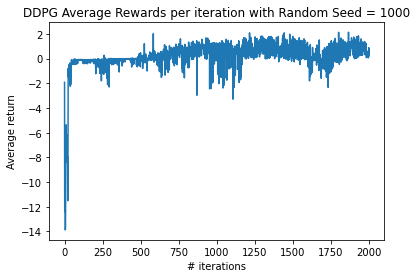

In [9]:
# plot for the return after each policy update.
plt.figure()
plt.plot(average_reward)
plt.xlabel('# iterations')
plt.ylabel('Average return')
plt.title('DDPG Average Rewards per iteration with Random Seed = {}'.format(1000))
plt.show()